# 3. Projektarbeit - Regression von Häuserpreisen mittels KNN
© Thomas Robert Holy 2020
<br>
Version 1.0
<br><br>
Visit me on GitHub: https://github.com/trh0ly
<br>
Kaggle Link: https://www.kaggle.com/c/dda-p3/leaderboard
## Grundlegene Einstellungen
### Import der Bibliotheken

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import seaborn as sns
from keras import metrics
import keras
import sys
from keras.models import Sequential
import operator
from keras.layers import Dense
from keras import optimizers 
from keras import losses
from keras import activations
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import BatchNormalization
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout
from keras import regularizers
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML


Using TensorFlow backend.


### Optikeinstellungen

In [2]:

%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;


<IPython.core.display.Javascript object>

In [3]:

display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.width = 500
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
plt.rcParams['figure.figsize'] = (12, 6)
SCREEN_WIDTH = 100
centered = operator.methodcaller('center', SCREEN_WIDTH)


## Definition von Hilfsfunktionen
### Definition One-Hot-Encoding Funktion 

In [4]:

# Definition einer Funktion, die das One-Hot-Encoding durchführt
#------------
# Argumente:
# - df: DataFrame welcher bearbeitet werden soll
# - df_row: DataFrame-Spalte die bearbeitet werden soll
# - make_df: 
# ---> Wenn False, dann werden die transformierten Werte als Array zurückgegeben
# ---> Wenn True, dann wird ein DataFrame zurückgegeben
# - overwrite_inv_encoded:
# ---> Wenn None, dann werden Spaltennamen des DataFrames auf Grundlage der Merkmals-
#      ausprägungen im originalen DataFrame ermittelt
# ---> Wenn != None, dann werden die Spalten manuell überschrieben
#------------

def onehot_encoder_func(df, df_row, make_df=False, overwrite_inv_encoded=None):
    values = np.array(df[df_row]) # Transformation der DataFrame-Saplte in ein Numpy Array
    label_encoder = LabelEncoder() # Definition des Label-Encoders
    integer_encoded = label_encoder.fit_transform(values.ravel()) # Label-Encoder auf Values fitten
    onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore') # Definition des One-Hot-Encoders
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1) # Reshape der Integer-Encoded Values
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded) # One-Hot-Encoder auf Values fitten
    """
    Wenn make_df == False:
    Rückgabe der One-Hot-Encoded 
    Values als Array
    """
    if make_df == False:
        return onehot_encoded # Rückgabe One-Hot-Endcoded Array
    """
    Wenn make_df == True:
    Rückgabe der One-Hot-Encoded 
    Values als DataFrame
    """
    if make_df == True:
        """
        Wenn overwrite_inv_encoded == None:
        Spalten des DataFrame werden nicht
        manuell überschrieben. Die Spaltennamen
        werden aus den Mermalsausprägungen des
        originalen DataFrame gewonnen.
        """
        if overwrite_inv_encoded == None:
            counter, array = 0, [] # Zähler, Main-Array werden inizialisiert
            # For-Schleife, welche ein Arrays mit Arrays generiert, welche
            # von i=0 bis i=len(onehot_encoded) jeweils eine 1 enthalten
            for i in range(0, len(onehot_encoded[0])):
                temp = [0] * len(onehot_encoded[0]) # Temporäres Array
                temp[i] = 1 # Variable i im temporären Array wird 1 gesetzt
                array.append(temp) # Generiertes Array wird dem Main-Array angefügt
            inv_encoded = onehot_encoder.inverse_transform(array) # Inverse Transformation One-Hot-Encoder
            inv_encoded = label_encoder.inverse_transform(inv_encoded.astype(int).ravel()) # Inverse Transformation Label-Encoder 
            # Generierung des DataFrames mit den One-Hot-Encoded Values und originalen Merkmalsausprägungen als Spalten-Namen
            encoded_df = pd.DataFrame(onehot_encoded, dtype=float, columns=list(inv_encoded), index=df.index)  
            df_ids = df.Id.values.tolist() # Indexspalte bzw. Einträge extrahieren        
            encoded_df['Id'] = df_ids # Im encoded_df eine Indexspalteanlegen...
            encoded_df = encoded_df.set_index('Id') # ... und als Index serzen
            return encoded_df # Rückgabe DataFrame
        """
        Wenn overwrite_inv_encoded != None:
        Spalten des DataFrame werden manuell
        überschrieben sofern Übergebene Array
        genügend Spaltennamen enthält.
        """
        if overwrite_inv_encoded != None:
            # Prüfung ob die Länge des manuell festgelegten Arrays gleich 
            # der Länge eines Arrays ist, welches aus den One-Hot-Endcoded
            # Values resultiert.
            case = len(overwrite_inv_encoded) == (len(onehot_encoded[0]))
            """
            # Sofern case = True werden die Spalten
            wie gewünscht überschrieben
            """
            if case == True:            
                # Generierung des DataFrames mit den One-Hot-Encoded Values und manuell überschriebenen Spalten-Namen
                encoded_df = pd.DataFrame(onehot_encoded, dtype=float, columns=list(overwrite_inv_encoded), index=df.index)
                return encoded_df # Rückgabe DataFrame
                """
                ERROR MESSAGE sofern "overwrite_inv_encoded"
                nicht lang genug.
                """
            else: 
                ERROR = 'ERROR Len of "overwrite_inv_encoded" have to be {}!'.format(len(onehot_encoded[0]))
                return ERROR
        """   
        ERROR MESSAGE sofern "make_df"
        kein gültiges Argument erhält.
        """
    else:
        print('ERROR: "make_df" needs an Argument!')
        

### Funktion zur Durchführung des Encodings und joinen der Teil-DataFrames

In [5]:

# Definition einer Funktion, die einen DataFrame und eine Liste als Argumente erhält und anschließend
# für jedes Element der Liste das One-Hot-Enconding im DataFrame durchführt.
#------------
# Argumente:
# - df1: DataFrame welcher bearbeitet werden soll
# - liste_ Liste, die abgearbeitet werden soll
#------------

def encode(df1, liste):
    #--------------------------------
    # Kopie des originalen DataFrames anlegen und Spalte Id als Index setzen
    df2 = df1.copy() 
    df2 = df2.set_index('Id')   
    #--------------------------------
    # One-Hote-Encoding auf Grundlage der Datentypliste mit Objekten durchführen
    onehot_encoded_df_list = []
    for i in liste:
        # Versuche ein One-Hot-Encoding durchzuführen
        try:
            #--------------------------------
            # Führe das Encoding durch und füge die Werte einer Liste an, dann entferne die originale Spalte     
            onehot_encoded = onehot_encoder_func(df1, str(i), make_df=True)
            onehot_encoded_df_list.append(onehot_encoded)            
            df2 = df2.drop(str(i), axis=1)   
        #--------------------------------
        # Bei Scheritern Meldung ausgeben und Spalte (zunächst) entferen
        except:
            print('ERROR in {}'.format(i))
            df2 = df2.drop(str(i), axis=1)
    #--------------------------------
    # Teil-DataFrames mit One-Hot-Endocding-Werten zusammenführen und ausgeben
    counter = 0
    for i in onehot_encoded_df_list:
        df2 = df2.join(i, lsuffix=str(counter))
        counter += 1        
    return df2


### Funktion zur Datenbereinigung (NaN-Werte)

In [6]:

# Definition einer Funktion, die eine automatisierte Entferunung von Spalten mit zu vielen NaN-Werten (über einem festgelegten Schwellenwert)
# vornimmt und automatisch Spalten mit einer vorgegebenen Methode füllt, welche den Schwellenwert nicht überschreitzen.
#------------
# Argumente:
# - df: DataFrame welcher bearbeitet werden soll
# - upper_limit: Schwellenwert ab welchem die Spalte gelöscht werden soll
# - method: Methode mit der NaN-Werte in Spalten, welche nicht gelöscht werden, gefüllt werden
#------------

def clean_my_data(df, upper_limit=30):    
    #--------------------------------
    # Get isnull from dataframe and safe in list    
    isnull_list = df.isnull().sum()        
    #--------------------------------
    # get values and index of isnull_list
    value = isnull_list.values.tolist()
    index = isnull_list.index.tolist()    
    #--------------------------------
    # match value and index in one list
    isnull_list = []
    for i in range(0, len(index)):
        temp = (index[i], value[i])
        isnull_list.append(temp)        
    #--------------------------------
    # sort the list and kick values above upper_limit, safe that as capped_list
    isnull_list = sorted(isnull_list, key = lambda x: abs(x[1]), reverse=True)  
    capped_list = [i for i in isnull_list if abs(i[1]) <= 30]    
    #--------------------------------
    # get all elements from cappend list which got at least one nan-value
    nan_list = [i for i in capped_list if abs(i[1]) > 0]    
    #--------------------------------
    # extrakt the index from nan_list and safe  in to_fix_list
    to_fix_list = []
    for i in nan_list:
        to_fix_list.append(i[0])        
    #--------------------------------
    # fill all to_fix_colums with most common value 
    for i in to_fix_list:
        temp = df[str(i)].value_counts().idxmax()
        df[str(i)] = df[str(i)].replace(np.nan, temp)  
    #--------------------------------
    # extrakt the index from isnull_list and safe it in feature_list
    feature_list = []
    for i in capped_list:
        feature_list.append(i[0])
    #--------------------------------
    # filter the dataframe by the feature_list
    df = df.filter(items=feature_list)        
    return df


### Funktion für die Separierung von Datentypen eines DataFrames

In [7]:

# Definition einer Funktion, die einen DataFrame erhält und daraufhin automatisch die Datentypen
# in verschiedene Listen separiert, um diese mittels One-Hot-Endocding aufbereiten zu können
#------------
# Argumente:
# - df: DataFrame welcher bearbeitet werden soll
#------------

def separate_dtypes(df):
    #--------------------------------
    # Get dtypes from dataframe and safe in list  
    values = df.dtypes.values.tolist()
    index = df.dtypes.index.tolist()
    #--------------------------------
    # match value and index in one list
    type_list = []
    for i in range(1, len(index)):
        temp = (index[i], values[i])
        type_list.append(temp)
    #--------------------------------
    # for each element of type_list determine type and safe in specific list
    int_list, object_list, float_list, other_list = [], [], [], []
    for i in range(0, len(type_list)):
        # Int-Werte
        if type_list[i][1] == 'int64':
            int_list.append(type_list[i][0])
        # Object-Werte
        elif type_list[i][1] == 'object':
            object_list.append(type_list[i][0])
        # Float-Werte
        elif type_list[i][1] == 'float64':
            float_list.append(type_list[i][0])
        # Andere Werte
        else:
            other_list.append(type_list[i][0])
            
    #--------------------------------
    # return lists as dictonary   
    my_dict = {'object':object_list, 'int64':int_list, 'float64':float_list, 'other':other_list}
    return my_dict


### Funktion für das Submitten

In [8]:

# Definition einer Funktion, welche das Submitten der Prognose auf dem Testdatensatz erleichert
#------------
# Argumente:
# - model: Modell auf Basis dessen die Prognose erfolgt
# - X_test: Datensatz aus Basis dessen die Prognose erfolgt
# - save:
# ---> Wenn False, dann werden die prognostizierten Daten nicht gespeichert
# ---> Wenn True, dann werden die prognostizierten Daten als .csv gespeichert
# - manu_name:
# ---> Wenn None, dann wird ein nicht eindeutiger Standardname als Bezeichnung der .csv gewählt
# ---> Wenn != None, dann wird die zu speichernde .csv mit einem timestamp versehen
#------------

def submit(model, X_test, y_scaler, save=False, manu_name=False):    
    #--------------------------------
    # predict on test set and inverse transformation for y values
    predicted_test = model.predict(X_test)    
    predicted_test = y_scalar.inverse_transform(predicted_test.reshape(-1, 1))
    #--------------------------------
    # Submissiondatensatz einlesen und prognostizierte Werte hineinschreiben
    submission = pd.read_csv('sample_submission.csv')
    submission['SalePrice'] = predicted_test    
    #--------------------------------
    # In .csv speichern, wenn save=True
    if save == True:        
        #--------------------------------
        # Standardnamen wählen, wenn manu_name == False
        if manu_name == False:
            submission.to_csv('./predicted_values.csv', index=False)            
        #--------------------------------
        # Standardnamen mit timestamp kombinieren, wenn  manu_name == True
        if manu_name == True:            
            import datetime 
            now = datetime.datetime.now()
            name = now.strftime('%Y-%m-%dT%H%M%S') + ('-%02d' % (now.microsecond / 10000))            
            submission.to_csv('./predicted_values_' + str(name) + '.csv', index=False)            
        
    #--------------------------------
    # return submission dataframe
    return submission


### Funktion zum Abgleich zweier Listen

In [9]:

# Definition einer Funktion, die zwei Listen miteinander abgleicht und deren
# gemeinsame Werten zurückgibt
#------------
# Argumente:
# - a: Lsite 1
# - b: Liste 2
#------------

def returnMatches(a, b, or_not_matches=False):
    #--------------------------------
    # check lists for matches
    if or_not_matches == False:
        matches = [x for x in a if x in b], [x for x in b if x in a]
    else:
        matches = [x for x in a if x not in b], [x for x in b if x not in a]
    #--------------------------------
    # return first or second array
    if len(matches[0]) == 0:        
        return matches[1]
    else:
        return matches[0]


### Funktion zum matchen zweier DataFrames

In [10]:

# Definition einer Funktion, die zwei DataFrame miteinander matcht, indem 
# nur gemeinsame Spalten übernommen werden
#------------
# Argumente:
# - a: Lsite 1
# - b: Liste 2
#------------

def match_train_and_test(train_data, test_data):
    #--------------------------------
    # get colum names form both dataframes
    a = train_data.columns.values.tolist()
    b = test_data.columns.values.tolist()
    #--------------------------------
    # return matches
    z = returnMatches(b, a)
    #--------------------------------
    # filter both dataframes to match them
    train_data = train_data.filter(items=z)
    test_data = test_data.filter(items=z)
    #--------------------------------
    # return matches dataframes    
    return train_data, test_data


### Funktion zur Ermittlung der Korrelation der DataFrame-Einträge mit der Zielgröße

In [11]:

# Definition einer Funktion, die die Korrelation aller Spaltenm mit der Zielgröße
# berechnet und ab einen bestimmten Schwellenwert Features entfernt
#------------
# Argumente:
# - df: Zu bearbeitender DataFrame
# - down_limit: Limit ab welchen Features zugelassen werden
#------------

def determine_corr_with_target_value(df, down_limit=0.01):
    #--------------------------------
    # Get corr with target vlaue from dataframe and safe in list  
    index = df.corrwith(df.SalePrice, axis=0).index.tolist()
    values = df.corrwith(df.SalePrice, axis=0).values.tolist()
    #--------------------------------
    # match value and index in one list
    corr_list = []
    for i in range(1, len(index)):
        temp = (index[i], values[i])
        corr_list.append(temp)
    #--------------------------------
    # sort corr_list and kick elemennts with corr below down_limit
    corr_list = sorted(corr_list, key = lambda x: abs(x[1]), reverse=True)  
    corr_list = [i for i in corr_list if abs(i[1]) >= down_limit]
    #--------------------------------
    # extrakt the elements that fulfill the specification and and safe themin feature_list
    feature_list = []
    for i in corr_list:
        feature_list.append(i[0])
    #--------------------------------
    # filter the dataframe by the feature_list
    df = df.filter(items=feature_list)
    #--------------------------------
    # dataframe
    return df


### Funktion zum Skalieren der Daten

In [14]:

# Definition einer Funktion, die die Skalierung der Daten vornimmt
#------------
# Argumente:
# - df: Zu bearbeitender DataFrame
# - my_scaler: Scaler der zur Sklalierung verwendet werden soll
#------------

def scale_it(df, my_scaler=StandardScaler):
    #--------------------------------
    # Define x and y data
    data = df.values
    X = data[:,:(len(df.columns) - 2)]
    y = data[:,(len(df.columns) - 1)]
    #--------------------------------
    # Scaling input data X
    scalar = my_scaler()
    scalar.fit(X)
    X = scalar.transform(X)
    #--------------------------------
    # Scaling input data y
    y = y.reshape(-1,1)
    y_scalar = my_scaler()
    y_scalar.fit(y)
    y = y_scalar.transform(y)
    #--------------------------------
    # return X, y and y_scaler for inverse scaling
    return X, y, y_scalar


### Funktion zur Vorbereitung der Testdaten

In [15]:

# Definition einer Funktion, die die Testdaten für das Submitten vorbereitetz
#------------
# Argumente:
# - test_data: Zu bearbeitender DataFrame
#------------

def make_test_data_fit(test_data, my_scaler=StandardScaler):
    #--------------------------------
    # Make array out of DataFrame
    data = test_data.values
    X = data[:,:(len(test_data.columns) - 1)]
    #--------------------------------
    # Scale and reutrn
    scalar = my_scaler()
    scalar.fit(X)
    X = scalar.transform(X)    
    return X


## Daten einlesen und modifizieren
### Ausgangsdaten einlesen und anzeigen

In [16]:

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
test_data['SalePrice'] = 0
train_data.head()


### Datensatz um NaN-Werte bereinigen
Saplten mit > 30 fehlenden Einträgen werden gelöscht. 
Bei Spalten in denen maximal 30 Einträge fehlen, werden diese durch den häufigsten Wert ersetzt.

In [17]:

#--------------------------------
# Datenbereinigung 
train_data = clean_my_data(train_data, upper_limit=30) 
test_data = clean_my_data(test_data, upper_limit=30) 
#--------------------------------
# Matchen
train_data, test_data = match_train_and_test(train_data, test_data)


## Datensatz um Ausreißer bereinigen
### Ermittlung der Datentypen
Die Datentypen in den DataFrames werden ermittelt sodass anschließend das One-Hot-Endocing für Spalten, welche Objekte enhtalten, durchgeführt werden kann.

In [18]:

#--------------------------------
# Ermittlung Datentypen
object_list = separate_dtypes(train_data)['object'] 
object_list.append('BsmtExposure')


### Durchführung One-Hot-Encoding
Nominale Features werden rechenbar gemacht.

In [19]:

#--------------------------------
# Durchführung One-Hot-Encoding
train_data = encode(train_data, object_list)
test_data = encode(test_data, object_list)
#--------------------------------
# Matchen
train_data, test_data = match_train_and_test(train_data, test_data)


### Feature Selektion (Korrelation)
Entfernung von Spalten, die sehr wenig mit der Zielgröße korrelieren.

In [22]:

print(train_data.shape)

#--------------------------------
# Feature Selektion anhand der Korrelation
train_data = determine_corr_with_target_value(train_data, down_limit=0.4)
#--------------------------------
# Matchen
train_data, test_data = match_train_and_test(train_data, test_data)
#--------------------------------
# Bug beheben
trainSale = train_data['SalePrice'].values.tolist()
train_data = train_data.drop('SalePrice', axis=1)
test_data = test_data.drop('SalePrice', axis=1)
train_data['SalePrice'] = trainSale

print(train_data.shape)

train_data.head()


(460, 224)
(460, 20)


,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,Ex21,TA2,NridgHt,Ex22,TA22,PConc,Ex,TA,SalePrice
Id,,,,,,,,,,,,,,,,,,,,
670,4,1922,1950,700,1180,1180,1,5,1,1,252,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,137500
958,5,1962,1962,1057,1057,1057,1,6,0,2,576,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,132000
614,5,2007,2007,1120,1120,1120,1,6,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,147000
83,8,2007,2007,1563,1563,1563,2,6,1,3,758,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,245000
1183,10,1996,1996,2396,2411,4476,3,10,2,3,813,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,745000


## Korrelation aller Features untereinander
Überprüfung inwieweit sich weitere Features entfernen lassen, da sie stark mit einem anderen starker mit der Zielgröße korrelierenden Feature zusammenhängen.
### Visualisierung

(20.0, 0.0)

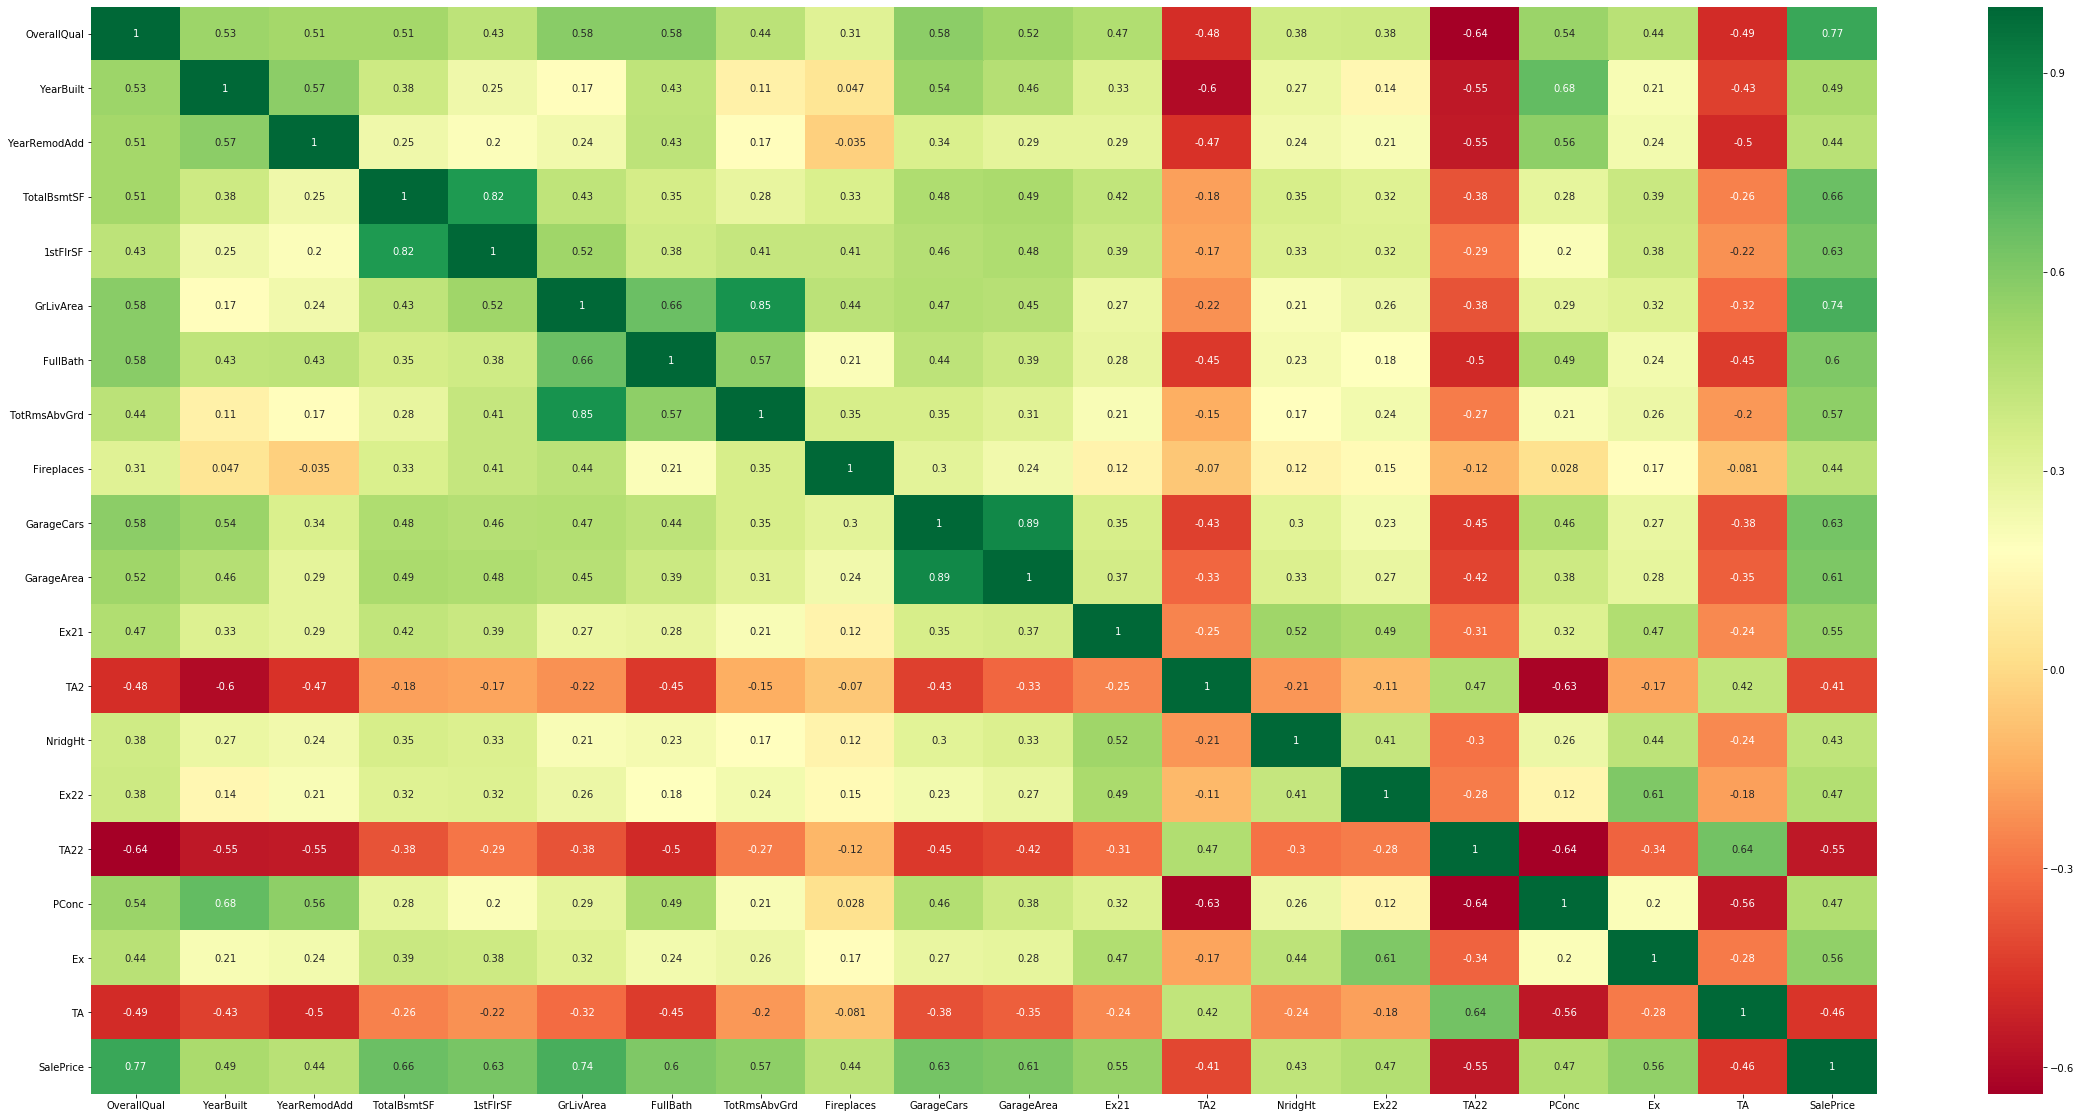

In [23]:

#--------------------------------
# Heatmap Plotten
X = train_data.drop('SalePrice',axis='columns') # Independent columns
y = train_data['SalePrice'] # Target column
corrmat = train_data.corr() # Get correlations of each features in dataset
top_corr_features = corrmat.index
plt.figure(figsize=(40,20)) # Größe Grafik
ax = sns.heatmap(train_data[top_corr_features].corr(),annot=True,cmap="RdYlGn") # Plot heat map
bottom, top = ax.get_ylim() # Get limits X-, Y-Achse                 
ax.set_ylim(bottom + 0.5, top - 0.5) # Erweiterterung der Limits


### Entfernung von untereinander stark korrelierten Features

In [24]:

_ = train_data.drop('1stFlrSF',axis='columns')
#train_data.drop('TotalBsmtSF',axis='columns')

_ = train_data.drop('GrLivArea',axis='columns')
#train_data.drop('TotRmsAbvGrd',axis='columns')

_ = train_data.drop('GarageCars',axis='columns')
#train_data.drop('GarageArea',axis='columns')
train_data.shape


(460, 20)

### Trainigsdatensatz skalieren und in Teildatatensätze splitten
Hinweis: Zum finalen Traing (so wie hier geschehen) wird der gesamte zur Verfügung stehende Traingsdatensatz verwednet, da dies bessere Ergebnisse auf Kaggle mit sich brachte.

In [25]:

#--------------------------------
# Skalierung
X, y, y_scalar = scale_it(train_data, my_scaler=RobustScaler)
#--------------------------------
# Splitten
X_train, X_validierung, y_train, y_validierung = train_test_split(X, y, test_size=0.2, random_state=2121)


## Prognose anhand eines KNN mittels Keras (Regression)
### Modell defininieren
Die Architiektur des Modells wird definiert.

In [26]:

def create_model( my_layer_units, my_learn_rate, my_dropout,
                 my_weight_constraint, my_regularizer, my_kernel_initializer, my_activation, input_dim=X_train.shape[1]):
    
    #--------------------------------
    # Create model and define optimizer
    model = Sequential()
    my_optimizer = optimizers.Adam(lr=my_learn_rate)
    
    #--------------------------------
    # Input layer
    model.add(Dense(int(my_layer_units * 1), input_dim=input_dim, kernel_regularizer=my_regularizer,
                    kernel_initializer=my_kernel_initializer, activation=my_activation,
                    kernel_constraint=maxnorm(my_weight_constraint)))
    
    #--------------------------------
    # Hidden layer 1         
    model.add(Dense(int(my_layer_units * 1), kernel_regularizer=my_regularizer,
                    kernel_initializer=my_kernel_initializer, activation=my_activation,
                    kernel_constraint=maxnorm(my_weight_constraint)))
    #--------------------------------
    # Dropout und hidden layer 2
    model.add(Dropout(my_dropout)) 
    model.add(Dense(int(my_layer_units * 1), kernel_regularizer=my_regularizer,
                    kernel_initializer=my_kernel_initializer, activation=my_activation,
                    kernel_constraint=maxnorm(my_weight_constraint)))
    
    #--------------------------------
    # Dropout und hidden layer 3        
    model.add(Dropout(my_dropout)) 
    model.add(Dense(int(my_layer_units * 1), kernel_regularizer=my_regularizer,
                    kernel_initializer=my_kernel_initializer,  activation=my_activation,
                    kernel_constraint=maxnorm(my_weight_constraint)))
    
    #--------------------------------
    # Dropout und hidden layer 4      
    model.add(Dropout(my_dropout)) 
    model.add(Dense(int(my_layer_units * 1), kernel_regularizer=my_regularizer,
                    kernel_initializer=my_kernel_initializer,  activation=my_activation,
                    kernel_constraint=maxnorm(my_weight_constraint)))
    
    #--------------------------------
    # Dropout und hidden layer 5    
    model.add(Dropout(my_dropout)) 
    model.add(Dense(int(my_layer_units * 1), kernel_regularizer=my_regularizer,
                    kernel_initializer=my_kernel_initializer,  activation=my_activation,
                    kernel_constraint=maxnorm(my_weight_constraint)))
    
    #--------------------------------
    # Dropout und hidden layer 6        
    model.add(Dropout(my_dropout)) 
    model.add(Dense(int(my_layer_units * 1), kernel_regularizer=my_regularizer,
                    kernel_initializer=my_kernel_initializer,  activation=my_activation,
                    kernel_constraint=maxnorm(my_weight_constraint)))
    
    #--------------------------------
    # Output layer
    model.add(Dense(1, activation='linear'))
    #--------------------------------
    # Compile model and return    
    model.compile(optimizer=my_optimizer, loss = 'mean_squared_error')    
    return model


### Parameter für die Kreuzvaliderung definieren

In [27]:

#--------------------------------
# Listen mit zu testenden Parametern
batch_size_list = [15]#, 5, 25, 30, 50]
epochs_list = [75]#, 25, 50, 150, 250]#, 500, 1000]
learn_rate_list = [0.0001]#, 0.001, 0.01]
dropout_list = [0.0]#, 0.1, 0.3, 0.5]
weight_constraint = [None]#, 1, 2, 3]
layer_unit_list = [140]#, 20, 50, 80, 120, 180]#, 120, 160]
kernel_initializer_list = ['uniform']#, 'normal', 'lecun_uniform', 'uniform', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
regularizer_list = [None]#, regularizers.l2(0.001), regularizers.l2(0.01)]
activation_list = ['relu']#, 'tanh', 'sigmoid']#, 'hard_sigmoid', 'linear', 'softmax', 'softplus', 'softsign'] 

#--------------------------------
# Erstellung Dictonary mit parametern
param_grid = {'batch_size': batch_size_list,
              'epochs': epochs_list,
              'my_layer_units': layer_unit_list,
              'my_learn_rate': learn_rate_list,
              'my_dropout': dropout_list,
              'my_regularizer': regularizer_list,
              'my_activation': activation_list,
              'my_kernel_initializer': kernel_initializer_list,
              'my_weight_constraint': weight_constraint}


### Modell finalisieren und Kreuzvaliderung starten

In [28]:
"""
#--------------------------------
# Modell finalisieren
model = KerasRegressor(build_fn=create_model, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=10)

#--------------------------------
# Kreuzvaliderung starten
grid_result = grid.fit(X, y)
"""

'\n#--------------------------------\n# Modell finalisieren\nmodel = KerasRegressor(build_fn=create_model, verbose=0)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=10)\n\n#--------------------------------\n# Kreuzvaliderung starten\ngrid_result = grid.fit(X, y)\n'

### Ausgabe der besten Parameterkombination

In [ ]:
"""
print('MSE for best found hyperparameter combitnation: {} with params: {}'.format(grid_result.best_score_, grid_result.best_params_))
"""

## Alternatives Modell ohne Kreuzvaliderung

In [29]:

model = create_model(my_layer_units=140, my_learn_rate=0.0001, my_dropout=0.0,
                     my_weight_constraint=None, my_regularizer=None, my_kernel_initializer='normal',
                     my_activation='relu', input_dim=X_train.shape[1])

model.fit(x=X, y=y, batch_size=15, verbose=2, epochs=40)


Epoch 1/40
 - 0s - loss: 1.0356
Epoch 2/40
 - 0s - loss: 1.0095
Epoch 3/40
 - 0s - loss: 0.8904
Epoch 4/40
 - 0s - loss: 0.5008
Epoch 5/40
 - 0s - loss: 0.2658
Epoch 6/40
 - 0s - loss: 0.2420
Epoch 7/40
 - 0s - loss: 0.1796
Epoch 8/40
 - 0s - loss: 0.2195
Epoch 9/40
 - 0s - loss: 0.1991
Epoch 10/40
 - 0s - loss: 0.1796
Epoch 11/40
 - 0s - loss: 0.1835
Epoch 12/40
 - 0s - loss: 0.1765
Epoch 13/40
 - 0s - loss: 0.1394
Epoch 14/40
 - 0s - loss: 0.1782
Epoch 15/40
 - 0s - loss: 0.1634
Epoch 16/40
 - 0s - loss: 0.1678
Epoch 17/40
 - 0s - loss: 0.1695
Epoch 18/40
 - 0s - loss: 0.1325
Epoch 19/40
 - 0s - loss: 0.1478
Epoch 20/40
 - 0s - loss: 0.1306
Epoch 21/40
 - 0s - loss: 0.1473
Epoch 22/40
 - 0s - loss: 0.1408
Epoch 23/40
 - 0s - loss: 0.1225
Epoch 24/40
 - 0s - loss: 0.1304
Epoch 25/40
 - 0s - loss: 0.1468
Epoch 26/40
 - 0s - loss: 0.1367
Epoch 27/40
 - 0s - loss: 0.1299
Epoch 28/40
 - 0s - loss: 0.1090
Epoch 29/40
 - 0s - loss: 0.1355
Epoch 30/40
 - 0s - loss: 0.1343
Epoch 31/40
 - 0s -

### Prognose
#### Auf den Testdaten

In [30]:

pred = model.predict(X)
pred = y_scalar.inverse_transform(pred.reshape(-1, 1))
pred[:5]


array([[108414.016],
       [136084.05 ],
       [133209.62 ],
       [247302.9  ],
       [624315.94 ]], dtype=float32)

In [31]:

test = y_scalar.inverse_transform(y)[:5]
test


array([[137500.],
       [132000.],
       [147000.],
       [245000.],
       [745000.]])

#### Auf den Validierungsdaten

In [32]:

pred = model.predict(X_validierung)
pred = y_scalar.inverse_transform(pred.reshape(-1, 1))
pred[:5]


array([[298377.06],
       [129082.86],
       [119308.51],
       [152271.42],
       [181709.47]], dtype=float32)

In [33]:

test = y_scalar.inverse_transform(y_validierung)[:5]
test


array([[310000.],
       [131000.],
       [110000.],
       [155000.],
       [174000.]])

#### Testdaten fit machen und Submit durchführen

In [34]:

#--------------------------------
# Fit machen
X = make_test_data_fit(test_data, my_scaler=RobustScaler)
#--------------------------------
# Submitten
submission = submit(model, X, y_scalar, save=True, manu_name=True)
submission.head()


,Id,SalePrice
0,478,405431.31250
1,311,174138.71875
2,798,103350.93750
3,795,197373.25000
4,247,140921.96875


#### Betrachtung der Verteilung auf Testdatensatz

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025D7011F488>]],
      dtype=object)

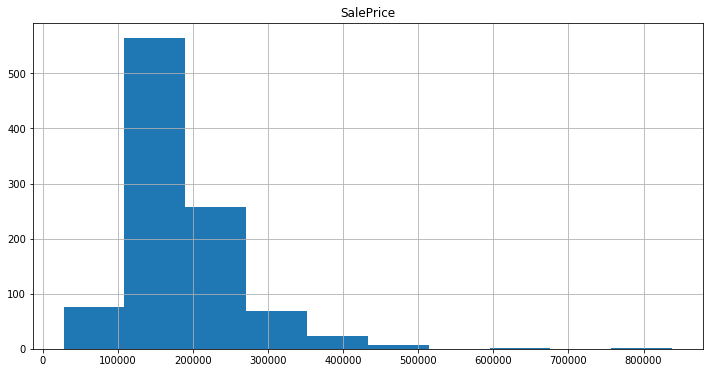

In [35]:

submission.hist(column=['SalePrice'])  


In [36]:

submission['SalePrice'].describe()


count      1000.000000
mean     181470.609375
std       75372.414062
min       27863.453125
25%      131303.710938
50%      156153.726562
75%      211499.222656
max      838150.437500
Name: SalePrice, dtype: float64

### Verteilung Traingsdatensatz zum Vergleich

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025D70340EC8>]],
      dtype=object)

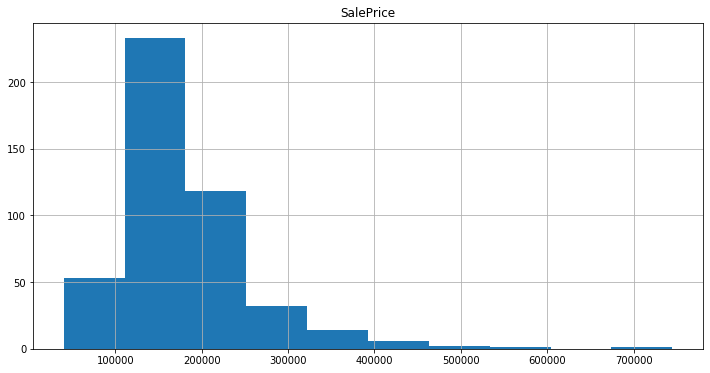

In [37]:

train_data.hist(column=['SalePrice'])  


In [38]:

train_data['SalePrice'].describe()


count       460.000000
mean     179771.752174
std       77419.758683
min       40000.000000
25%      130187.500000
50%      162950.000000
75%      207750.000000
max      745000.000000
Name: SalePrice, dtype: float64